In [2395]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import folium
import seaborn as sns
from helpers import parse_feature_metadata
import osmnx as ox
import geopandas as gpd

Please set this constant to false if you wish the cells not to plot graphs

In [2396]:
PLOT_GRAPHS = False

Local paths should be correct if repository was cloned

In [2397]:
NEPAL_PATH = r"data\raw_updated_names\nepal_new_feature_names.xlsx"
SENEGAL_PATH = r"data\raw_updated_names\senegal_new_feature_names.xlsx"

nepal_df = pd.read_excel(NEPAL_PATH, index_col=0)
senegal_df = pd.read_excel(SENEGAL_PATH, index_col=0)

## 1. Initial Parsing of the Data
This phase includes removal of features that we from the start knew we would not use or would not be beneficial, and also coerces the remaining features's values to be their declared types

In [2398]:

NEPAL_CAT_COL_NAMES = {'Q11': 'Marital_Status',
 'Q53': 'What_type_of_crop_is_grown_on_this_plot',
 'Q54': 'For_vegetables_what_is_your_source_of_seeds',
 'Q56': 'For_vegetables_do_you_use_seedlings',
 'Q58': 'fertilizer_on_this_plot',
 'Q63': 'What_is_the_main_use_of_produce_from_holding',
 'Q64': 'Do_you_use_machinery_or_and_equipment_on_the_plot',
 'Q65': 'Do_you_do_any_of_the_following',
 'Q67': 'What_do_you_use_soil_analysis_for',
 'Q68': 'How_do_you_conduct_soil_analysis',
 'Q69': 'What_is_correct_for_you',
 'Q71': 'in_the_past_12_months_from_who_did_you_receive_info_on_agriculture',
 'Q73': 'Did_you_receive_anything_from_these_organizations',
 'Q74': 'How_do_you_decide_to_plow',
 'Q75': 'How_do_you_decide_to_begin_sowing',
 'Q76': 'What_type_of_irrigation_do_you_use',
 'Q100': 'Caste',
 'Q105': 'main_sources_of_income',
 'Q111': 'Generally_speaking_would_you_say_that_most_people_can_be_trusted',
 'Q112': 'I_am_much_better_than_most_farmers_here',
 'Q113': 'dislike_not_knowing_what_is_going_to_happen'}

SENEGAL_CAT_COL_NAMES = {'Q63': 'CROP',
 'Q64': 'Seed_source',
 'Q65': 'Variety',
 'Q66': 'Seedlings',
 'Q67': 'Fertilizer',
 'Q72': 'Sold_VEG',
 'Q73': 'Machinery',
 'Q74': 'Practice',
 'Q77': 'Info_source',
 'Q79': 'Did_you_receive_anything_from_the_specified_organizations',
 'Q80': 'Plow_weather',
 'Q81': 'Sow',
 'Q82': 'Irrigation',
 'Q88': 'family_main_sources_income',
 'Q89': 'education_level'}

def fix_column_values(series: pd.Series, meta: dict) -> pd.Series:
    """
    Given a pandas Series and its parsed metadata,
    coerce its values to the right type:
      - continuous, ordinal → numeric (floats or ints; bad → NaN)
      - nominal -> categorical
      - binary → 0/1 integers   (anything non-zero → 1, missing -> NaN)
      - time   → pandas datetime (bad → NaT)
    """
    ftype = meta["type"]
    fname = meta["name"].lower()

    if ftype in ("continuous", "ordinal"):
        # numeric codes or measurements
        return pd.to_numeric(series, errors="coerce")
    if ftype == "nominal":
        return series.astype("category")
    if "binary" in ftype:
        # strings that are not '0': → 1, otherwise __> 0, floats/ints: non-zero → 1, zero or NaN → 0
        def to_binary(x):
            if pd.isna(x):
                return pd.NA
            if isinstance(x, str):
                return x != '0'
            try:
                return 1 if float(x) != 0 else 0
            except:
                return 1
        return series.map(to_binary).astype("Int64")

    if ftype == "time":
        # Force everything to str so we have uniform input
        s = series.astype(str)
        # 0) special: End_Date holds a full datetime → extract only the time
        if "end_date" in fname:
            # parses strings like "4/27/2018 9:47:17 AM" into Timestamps
            dt = pd.to_datetime(s, errors="coerce")
            # grab Python datetime.time
            return dt.dt.time
        # 1) true date column → datetime64
        if "date" in fname:
            return pd.to_datetime(s, format="%Y-%m-%d", errors="coerce")

        # 2) survey‐length durations → timedelta64
        if "length" in fname:
            # strings like "00:21:14" → Timedelta
            return pd.to_timedelta(s, errors="coerce")

        # 3) the two pure clock‐time columns → Python time
        #    strings like "11:27:52" → Timestamp → .time()
        parsed = pd.to_datetime(s, format="%H:%M:%S", errors="coerce")
        return parsed.dt.time

    # otherwise leave it alone
    return series


def clean_survey_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """
    Returns a copy of df in which:
      - all columns named Q<digits>__… have been coerced to their declared types
      - all other columns are left untouched (you can drop them later)
    """
    df = df.copy()
    for col in df.columns:
        meta = parse_feature_metadata(col)
        if meta is None:
            continue
        df[col] = fix_column_values(df[col], meta)
    return df


def drop_non_relevant_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Remove everything except Q<digits> columns:
    """
    keep = [col for col in df.columns if parse_feature_metadata(col) is not None]
    return df[keep]

import pandas as pd
from collections import defaultdict

def combine_dummy_columns(orig_df: pd.DataFrame, names_dict: dict) -> pd.DataFrame:
    """
    Combines your binary dummy columns into single categorical columns,
    but now *preserves* the option labels.

    For each (qid, type):
      - If there's exactly one dummy → just rename it to end in `-1`.
      - If there are many and it's one-hot (max 1 per row) → new column takes the option LABEL, or None.
      - Otherwise (multi-select) → new column is a list of the LABELS selected (possibly empty).
    """
    df = orig_df.copy()

    # 1) Gather metadata & group columns by (qid, type)
    meta_map   = {}               # col_name → {qid, qname, var_type, dummy_idx, label}
    buckets    = defaultdict(list)

    for col in df.columns:
        if "binary" not in col:
            continue
        m = parse_feature_metadata(col)
        qid        = m["qid"]
        qname      = m["name"]
        var_type   = m["type"]
        dummy_idx  = m["dummy"]
        
        subnames = qname.split(':')
        label      = qname

        meta_map[col] = {
            "qid":       qid,
            "qname":     qname,
            "var_type":  var_type,
            "dummy_idx": dummy_idx,
            "label":     label
        }
        buckets[(qid, var_type)].append(col)

    to_drop  = []
    new_cols = {}

    # 2) Process each question group
    for (qid, var_type), cols in buckets.items():
        # sort by dummy_idx so labels stay in the right order
        cols_sorted   = sorted(cols, key=lambda c: meta_map[c]["dummy_idx"])
        labels_sorted = [meta_map[c]["label"] for c in cols_sorted]
        arr           = df[cols_sorted].fillna(0).astype(int).values

        # A) Single-dummy → just rename it to ...-1
        if len(cols_sorted) == 1:
            old = cols_sorted[0]
            new = f"{qid}__{meta_map[old]['qname']}__binary__1"
            df = df.rename(columns={old: new})
            continue
        

        new_type = "nominal" if var_type.endswith("nominal") else "ordinal"
        qname = names_dict[qid]
        new_name = f"{qid}__{qname}__{new_type}"
        

        # B) One-hot? (no row has more than one “1”)
        if arr.sum(axis=1).max() <= 1:
            cat = []
            for row in arr:
                if row.sum() == 0:
                    cat.append(None)
                else:
                    cat.append(labels_sorted[row.argmax()])
            
            new_cols[new_name] = cat

        # C) Multi-select
        else:
            multi = []
            for row in arr:
                # collect all the labels whose dummy==1
                sel = [labels_sorted[i] for i, v in enumerate(row) if v == 1]
                multi.append(tuple(sel))
            new_cols[new_name] = multi

        to_drop.extend(cols_sorted)

    # 3) Drop old dummies & add the new columns
    if to_drop:
        df = df.drop(columns=to_drop)
        df = pd.concat([df, pd.DataFrame(new_cols, index=df.index)], axis=1)

    return df, new_cols



In [2399]:
# dropping non Q#... columns
nepal_df = drop_non_relevant_columns(nepal_df)
senegal_df = drop_non_relevant_columns(senegal_df)

# initial clean
nepal_df = clean_survey_dataframe(nepal_df)
senegal_df = clean_survey_dataframe(senegal_df)

# combine and remove dummy columns
nepal_df, npl_new_cols = combine_dummy_columns(nepal_df, NEPAL_CAT_COL_NAMES)
senegal_df, sng_new_cols = combine_dummy_columns(senegal_df, SENEGAL_CAT_COL_NAMES)

# Univariate Analysis

## Analyze Datetime columns

Create mew datetime column

In [2400]:


nepal_df['Q2__SurveyedDate__time'] = pd.to_datetime(nepal_df['Q2__SurveyedDate__time'], errors='coerce')

def create_datetime_col(df):
    # ensure your date column is datetime64
    df['Q2__SurveyedDate__time'] = pd.to_datetime(
        df['Q2__SurveyedDate__time'], format="%Y-%m-%d", errors='coerce'
    )

    # 1) build an all‐string “HH:MM:SS” series
    time_str = df['Q2__SurveyedTime__time'].astype(str).str.extract(r'(\d{2}:\d{2}:\d{2})')[0]

    # 2) combine
    dt_strings = df['Q2__SurveyedDate__time'].dt.strftime('%Y-%m-%d') + ' ' + time_str

    # 3) parse into real timestamps
    df['Q2__Surveyed_Date_Time__time'] = pd.to_datetime(dt_strings, errors='coerce')

    print(df['Q2__Surveyed_Date_Time__time'].dtype)  # should be datetime64[ns]
    
create_datetime_col(nepal_df)
create_datetime_col(senegal_df)

datetime64[ns]
datetime64[ns]


Removed old one since already have DateTime column

In [2401]:

nepal_df = nepal_df.drop(['Q2__SurveyedDate__time', 'Q2__SurveyedTime__time'], axis=1)
senegal_df = senegal_df.drop(['Q2__SurveyedDate__time', 'Q2__SurveyedTime__time'], axis=1)

Define function to analyze new datetime columns

In [2402]:

def analyze_datetime(df, col):
    """
    Perform univariate analysis on a datetime64 column:
      - prints basic stats (min, max, missing)
      - plots counts per day, month, weekday, and hour-of-day
    """
    # Basic info
    series = df[col]
    if not series.dtype.name.startswith('datetime'):
        raise ValueError(f"Column {col!r} is not datetime dtype.")
    
    print(f"\n--- ANALYSIS OF {col.upper()} ---")
    print(f"Type: {series.dtype}")
    print(f"Missing: {series.isna().sum()} / {len(series)}")
    print(f"Range: {series.min()} → {series.max()}")
    
    # Extract time features
    df_temp = df.dropna(subset=[col]).copy()
    df_temp['date']    = df_temp[col].dt.date
    df_temp['month']   = df_temp[col].dt.to_period('M').astype(str)
    df_temp['weekday'] = df_temp[col].dt.day_name()
    df_temp['hour']    = df_temp[col].dt.hour
    
    # 1. Counts per day
    daily = df_temp.groupby('date').size()
    plt.figure()
    daily.plot(kind='bar')
    plt.title(f"Number of Records per Day ({col})")
    plt.xlabel("Date")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # 2. Counts by month
    monthly = df_temp.groupby('month').size().sort_index()
    plt.figure()
    monthly.plot(kind='bar')
    plt.title(f"Counts by Month ({col})")
    plt.xlabel("Month")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # 3. Counts by weekday
    # ensure Mon–Sun order
    weekdays = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
    wd = df_temp['weekday'].value_counts().reindex(weekdays)
    plt.figure()
    wd.plot(kind='bar')
    plt.title(f"Counts by Weekday ({col})")
    plt.xlabel("Weekday")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()
    
    # 4. Distribution of hour of day
    plt.figure()
    sns.histplot(df_temp['hour'], bins=24, discrete=True, kde=False)
    plt.title(f"Survey Time of Day Distribution ({col})")
    plt.xlabel("Hour of Day")
    plt.ylabel("Count")
    plt.xticks(range(0,24))
    plt.tight_layout()
    plt.show()

    

Analyze new datetime columns

In [2403]:
if PLOT_GRAPHS: 
    print("NEPAL DATA")
    analyze_datetime(nepal_df, 'Q2__Surveyed_Date_Time__time')
    print("SENEGAL DATA")
    analyze_datetime(senegal_df, 'Q2__Surveyed_Date_Time__time')

## Analyze Survey Length

Add Survey_Length column

In [2404]:

# turn time → "HH:MM:SS" strings → Timedelta
nepal_df['Q0__SurveyLengthTime__time'] = (
    nepal_df['Q0__SurveyLengthTime__time']
      .astype(str)                # datetime.time → "HH:MM:SS"
      .pipe(pd.to_timedelta)      # parse into timedelta64[ns]
)

# first, make sure both your start‐ and end‐times are strings
senegal_df['Q2__Surveyed_Date_Time__time'] = senegal_df['Q2__Surveyed_Date_Time__time'].astype(str)
senegal_df['Q0__Surveyed_End_Date__time']   = senegal_df['Q0__Surveyed_End_Date__time'].astype(str)

# 1) Parse your “start” column as a real timestamp
senegal_df['start_dt'] = pd.to_datetime(
    senegal_df['Q2__Surveyed_Date_Time__time'],
    format='%Y-%m-%d %H:%M:%S'
)

# 2) Turn your “end time” (just HH:MM:SS) into a Timedelta
senegal_df['end_td'] = pd.to_timedelta(
    senegal_df['Q0__Surveyed_End_Date__time'].astype(str)
)

# 3) Build a full “end” timestamp by taking the date from start_dt and adding the time delta
senegal_df['end_dt'] = (
    senegal_df['start_dt'].dt.normalize()  # midnight of the start date
  + senegal_df['end_td']
)

senegal_df['Q0__SurveyLengthTime__time'] = senegal_df['end_dt'] - senegal_df['start_dt']

senegal_df.drop(columns=['start_dt', 'end_td', 'end_dt'], inplace=True)

Function to analyze Survey_Length column

In [2405]:
from matplotlib.ticker import FuncFormatter

def analyze_survey_length(df, column='Q0__SurveyLengthTime__time', bins=30):
    """
    Analyze the distribution of survey lengths in a DataFrame.

    Parameters
    ----------
    df : pandas.DataFrame
        The DataFrame containing the survey length column.
    column : str, default 'Survey_Length'
        Name of the timedelta column to analyze.
    bins : int, default 30
        Number of histogram bins.

    Outputs
    -------
    - Histogram of survey lengths (HH:MM:SS) distribution.
    - Printed mean and standard deviation of survey lengths.
    - Returns a tuple (mean_timedelta, std_timedelta).
    """
    # Ensure the column is timedelta64[ns]
    if not pd.api.types.is_timedelta64_dtype(df[column]):
        raise TypeError(f"Column '{column}' must be timedelta64[ns] dtype")

    # Compute statistics
    mean_td = df[column].mean()
    std_td = df[column].std()

    # Convert to total seconds for plotting
    secs = df[column].dt.total_seconds()

    # Plot histogram
    fig, ax = plt.subplots()
    ax.hist(secs, bins=bins)
    ax.set_title("Distribution of Survey Lengths")
    ax.set_xlabel("Survey Length (HH:MM:SS)")
    ax.set_ylabel("Frequency")

    # Formatter to convert seconds back to HH:MM:SS
    def sec_to_hhmmss(x, pos):
        h = int(x // 3600)
        m = int((x % 3600) // 60)
        s = int(x % 60)
        return f"{h:02d}:{m:02d}:{s:02d}"

    ax.xaxis.set_major_formatter(FuncFormatter(sec_to_hhmmss))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Print mean and std in HH:MM:SS
    mean_str = str(mean_td).split()[-1]
    std_str  = str(std_td).split()[-1]
    print(f"Mean survey length: {mean_str}")
    print(f"Std dev survey length: {std_str}")

    return mean_td, std_td

In [2406]:
if PLOT_GRAPHS:
    print("NEPAL DATA")
    analyze_survey_length(nepal_df)
    print("SENEGAL DATA")
    analyze_survey_length(senegal_df)

Discovered data-entry glitch extreme value at one Senegalese survey

In [2407]:
bad = senegal_df[ senegal_df['Q0__SurveyLengthTime__time'] < pd.Timedelta(0) ]
print(bad[['Q2__Surveyed_Date_Time__time','Q0__Surveyed_End_Date__time','Q0__SurveyLengthTime__time']])

    Q2__Surveyed_Date_Time__time Q0__Surveyed_End_Date__time  \
328          2018-04-27 14:18:09                    00:11:33   

    Q0__SurveyLengthTime__time  
328          -1 days +09:53:24  


Filling in this survey with median survey length

In [2408]:
median_td = senegal_df.loc[ senegal_df['Q0__SurveyLengthTime__time'] >= pd.Timedelta(0), 'Q0__SurveyLengthTime__time' ].median()
mask = senegal_df['Q0__SurveyLengthTime__time'] < pd.Timedelta(0)
print(f"Found {mask.sum()} negative Survey_Length(s), filling with median = {median_td}")
senegal_df.loc[mask, 'Q0__SurveyLengthTime__time'] = median_td

Found 1 negative Survey_Length(s), filling with median = 0 days 00:31:58


Redefine survey analysis function by adding standard deviation markers

In [2409]:
from matplotlib.ticker import FuncFormatter

def analyze_survey_length(df, column='Q0__SurveyLengthTime__time', bins=30, max_std=3):
    """
    Analyze the distribution of survey lengths in a DataFrame,
    and overlay vertical lines at mean ± n * std for n = 1..max_std.

    Parameters
    ----------
    df : pandas.DataFrame
        The DataFrame containing the survey length column.
    column : str, default 'Survey_Length'
        Name of the timedelta column to analyze.
    bins : int, default 30
        Number of histogram bins.
    max_std : int, default 3
        How many standard-deviation multiples to draw lines for.

    Outputs
    -------
    - Histogram of survey lengths (HH:MM:SS) distribution with σ-lines.
    - Printed mean and standard deviation of survey lengths.
    - Returns a tuple (mean_timedelta, std_timedelta).
    """
    # 1) Type check
    if not pd.api.types.is_timedelta64_dtype(df[column]):
        raise TypeError(f"Column '{column}' must be timedelta64[ns] dtype")

    # 2) Compute statistics
    mean_td = df[column].mean()
    std_td  = df[column].std()

    mean_sec = mean_td.total_seconds()
    std_sec  = std_td.total_seconds()

    # 3) Build histogram
    secs = df[column].dt.total_seconds()
    fig, ax = plt.subplots(figsize=(8,4))
    ax.hist(secs, bins=bins, edgecolor='black', alpha=0.7)
    ax.set_title("Distribution of Survey Lengths")
    ax.set_xlabel("Survey Length (HH:MM:SS)")
    ax.set_ylabel("Frequency")

    # Formatter: seconds → HH:MM:SS
    def sec_to_hhmmss(x, pos):
        h = int(x // 3600)
        m = int((x % 3600) // 60)
        s = int(x % 60)
        return f"{h:02d}:{m:02d}:{s:02d}"

    ax.xaxis.set_major_formatter(FuncFormatter(sec_to_hhmmss))
    plt.xticks(rotation=45)

    # 4) Overlay mean and std-bands
    #    use different linestyles/colors for clarity
    for n in range(0, max_std+1):
        # skip n=0 since that’s the mean line (draw it separately for legend clarity)
        if n == 0:
            ax.axvline(mean_sec, color='black', linestyle='-', linewidth=2,
                       label='Mean')
        else:
            for sign, label in [(+1, f'+{n}σ'), (-1, f'-{n}σ')]:
                x = mean_sec + sign * n * std_sec
                ax.axvline(x, linestyle='--' if n==1 else ':',
                           linewidth=1.5 if n==1 else 1,
                           label=label if sign>0 else None)
    # Only one -σ label needed, so we skip labeling the negative side

    ax.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

    # 5) Print out
    mean_str = str(mean_td).split()[-1]
    std_str  = str(std_td).split()[-1]
    print(f"Mean survey length: {mean_str}")
    print(f"Std dev survey length: {std_str}")

    return mean_td, std_td

In [2410]:
if PLOT_GRAPHS:
    print("SENEGAL DATA")
    analyze_survey_length(senegal_df)

Outliers defined as beyond 3 standard deviations, we swap outliers with median survey length

In [2411]:
threshold = senegal_df['Q0__SurveyLengthTime__time'].mean() + 2*senegal_df['Q0__SurveyLengthTime__time'].std()
mask = senegal_df['Q0__SurveyLengthTime__time'] > threshold
print(f"Changed {mask.sum()} outlier survey lengths to median")
senegal_df.loc[mask, 'Q0__SurveyLengthTime__time'] = median_td

Changed 3 outlier survey lengths to median


Recheck survey length histogram

In [2412]:
if PLOT_GRAPHS:
    print("SENEGAL DATA")
    analyze_survey_length(senegal_df)

## Analyze Locational Data

Since added Survey_Length column, took out others

In [2413]:

nepal_df = nepal_df.drop(['Q0__SurveyedEndTime__time'], axis=1)
senegal_df = senegal_df.drop(['Q0__Surveyed_End_Date__time'], axis=1)

Showing missing columns in the Senegal dataset's Location_... columns

In [2414]:
for column in ['Latitude', 'Longitude', 'Altitude', 'Accuracy']:
    print(f"missing values in Q1__Location_{column}: {senegal_df[f'Q1__Location_{column}__continuous'].isna().sum()}")
    print(f"missing values in {column}: {senegal_df[f'Q1__{column}__continuous'].isna().sum()}")


missing values in Q1__Location_Latitude: 335
missing values in Latitude: 0
missing values in Q1__Location_Longitude: 335
missing values in Longitude: 0
missing values in Q1__Location_Altitude: 335
missing values in Altitude: 0
missing values in Q1__Location_Accuracy: 335
missing values in Accuracy: 0


Removing Location_ columns from senegal data


In [2415]:
senegal_df = senegal_df.drop(['Q1__Location_Latitude__continuous', 'Q1__Location_Longitude__continuous', 'Q1__Location_Altitude__continuous', 'Q1__Location_Accuracy__continuous'], axis=1)

Both are ok for nepal

In [2416]:
for column in ['Latitude', 'Longitude', 'Altitude', 'Accuracy']:
    print(f"missing values in Location_{column}: {nepal_df[f'Q1__Location_{column}__continuous'].isna().sum()}")
    print(f"missing values in {column}: {nepal_df[f'Q1__{column}__continuous'].isna().sum()}")

missing values in Location_Latitude: 0
missing values in Latitude: 0
missing values in Location_Longitude: 0
missing values in Longitude: 0
missing values in Location_Altitude: 0
missing values in Altitude: 0
missing values in Location_Accuracy: 0
missing values in Accuracy: 0


Still removing from nepal Location_ columns for consistency between both datasets

In [2417]:
nepal_df = nepal_df.drop(['Q1__Location_Latitude__continuous', 'Q1__Location_Longitude__continuous', 'Q1__Location_Altitude__continuous', 'Q1__Location_Accuracy__continuous'], axis=1)

Defining function to analyze locational columns

In [2418]:

from folium.plugins import MarkerCluster

def lat_lon_hillshade_map(df, zoom_start=11):
    """
    Folium map with:
      • Default OpenStreetMap layer
      • ESRI World Hillshade (true terrain) layer
      • MarkerCluster of your points with Altitude pop-ups
      • LayerControl for toggling back and forth
    """
    # 1) Prepare & center
    df_map = df.dropna(subset=['Q1__Latitude__continuous','Q1__Longitude__continuous']).copy()
    center = [df_map['Q1__Latitude__continuous'].mean(), df_map['Q1__Longitude__continuous'].mean()]

    # 2) Build base map (OSM by default)
    m = folium.Map(location=center, zoom_start=zoom_start)

    # 3) Add ESRI World Hillshade as a second base layer
    folium.TileLayer(
        tiles='https://server.arcgisonline.com/ArcGIS/rest/services/'
              'Elevation/World_Hillshade/MapServer/tile/{z}/{y}/{x}',
        attr='Tiles © Esri — Source: USGS',
        name='Hillshade (ESRI)'
    ).add_to(m)

    # 4) Your markers (clustered)
    mc = MarkerCluster(name='Points').add_to(m)
    for idx, row in df_map.iterrows():
        folium.Marker(
            location=[row['Q1__Latitude__continuous'], row['Q1__Longitude__continuous']],
            popup=(
                f"<b>Index:</b> {idx}<br>"
                f"<b>Altitude:</b> {row.get('Q1__Altitude__continuous','N/A')} m"
            )
        ).add_to(mc)

    # 5) Toggle control
    folium.LayerControl(collapsed=False).add_to(m)

    return m


Analyze lat long data for nepal, both openstreetmap and hillshade for elevation

In [2419]:
if PLOT_GRAPHS:
    nepal_map = lat_lon_hillshade_map(nepal_df)
    nepal_map   # in Jupyter this will render with two base‐layers to switch between


The same for Senegal

In [2420]:
if PLOT_GRAPHS:
    print("SENEGAL DATA")
    senegal_map = lat_lon_hillshade_map(senegal_df)
    senegal_map


Check against google if the altitude column is accurate given the lat lot coordinates, plot accuracy also to see if there is some connection

In [2421]:
import requests

def plot_altitude_error(df, lat_col='Q1__Latitude__continuous', lon_col='Q1__Longitude__continuous', alt_col='Q1__Altitude__continuous', accuracy_col='Q1__Accuracy__continuous', api_url='https://api.open-elevation.com/api/v1/lookup', batch_size=100, bins=30):
    '''
    Fetches true elevations and plots a combined view showing:
      - Histogram of altitude errors (recorded - true).
      - Median reported accuracy for each error bin overlaid as a line.

    Parameters:
    df (pd.DataFrame): DataFrame with latitude, longitude, recorded altitude, and accuracy columns.
    lat_col (str): Name of the latitude column.
    lon_col (str): Name of the longitude column.
    alt_col (str): Name of the recorded altitude column.
    accuracy_col (str): Name of the accuracy column.
    api_url (str): Elevation API endpoint.
    batch_size (int): Number of locations per API request.
    bins (int): Number of bins for error histogram and averaging.

    Returns:
    None. Displays a joint plot of error distribution and median accuracy per error bin.
    '''
    # Work on a copy
    df = df.copy()
    true_alts = []

    # Batch request loop to fetch true elevations
    for i in range(0, len(df), batch_size):
        batch = df.iloc[i:i+batch_size]
        locations = '|'.join(f"{lat},{lon}" for lat, lon in zip(batch[lat_col], batch[lon_col]))
        resp = requests.get(api_url, params={'locations': locations})
        resp.raise_for_status()
        results = resp.json().get('results', [])
        if len(results) != len(batch):
            raise ValueError(f"Expected {len(batch)} results, got {len(results)}")
        true_alts.extend(r['elevation'] for r in results)

    # Compute errors and extract accuracy
    recorded = df[alt_col].values
    errors = recorded - np.array(true_alts)
    accuracies = df[accuracy_col].values

    # Prepare bins and compute median accuracy per bin
    bin_edges = np.linspace(errors.min(), errors.max(), bins + 1)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    digitized = np.digitize(errors, bin_edges) - 1
    median_acc = [np.median(accuracies[digitized == i]) if np.any(digitized == i) else np.nan for i in range(bins)]

    # Create combined plot
    fig, ax1 = plt.subplots()

    # Histogram of errors
    ax1.hist(errors, bins=bin_edges, alpha=0.6)
    ax1.set_xlabel('Altitude Error (m)')
    ax1.set_ylabel('Frequency')
    ax1.axvline(0, color='k', linestyle='--')


    plt.title('Altitude Error Distribution')
    plt.show()

In [2422]:
if PLOT_GRAPHS:
    plot_altitude_error(nepal_df)

In [2423]:
if PLOT_GRAPHS:
    plot_altitude_error(senegal_df)

Looks like gaussian noise error, adding approximate average to center errors 

In [2424]:
nepal_df["Q1__Altitude__continuous"] = nepal_df["Q1__Altitude__continuous"] + 62
senegal_df["Q1__Altitude__continuous"] = senegal_df["Q1__Altitude__continuous"] - 22

In [2425]:
if PLOT_GRAPHS:
    plot_altitude_error(nepal_df)

In [2426]:
if PLOT_GRAPHS:
    plot_altitude_error(senegal_df)

# Missing Values

View missing counts

In [2427]:
missing_counts_nepal = nepal_df.isnull().sum()
print("Missing values per column in nepal:")
print(missing_counts_nepal[missing_counts_nepal>0])


Missing values per column in nepal:
Q52__On_how_much_land_do_you_grow_vegetables_bigha__continuous                                     1
Q78__How_many_years_have_you_been_using_drip_irrigation_if_no_zero__continuous                     1
Q102__How_many_children_do_you_have__continuous                                                   17
Q103__How_many_children_do_you_plan_to_have_in_your_whole_live__continuous                        17
Q106__Education_level_of_this_person_that_is_interviewed_years_of_formal_education__continuous     1
Q109__What_is_your_households_yearly_income_overall_including_agriculture_NPR__continuous          1
Q111__Generally_speaking_would_you_say_that_most_people_can__ordinal                              11
Q11__Marital_Status__nominal                                                                      17
Q100__Caste__nominal                                                                              11
dtype: int64


In [2428]:
missing_counts_senegal = senegal_df.isnull().sum()
print("Missing values per column in senegal:")
print(missing_counts_senegal[missing_counts_senegal>0])



Missing values per column in senegal:
Q5__Age__continuous                            1
Q87__Household_size__continuous                3
Q0__Survey_duration__time                    335
Q0__Age_Education_interaction__continuous      1
Q89__education_level__nominal                201
dtype: int64


Drop almost completely missing columns in Senegal

In [2429]:
senegal_df = senegal_df.drop(columns=["Q0__Survey_duration__time", "Q89__education_level__nominal"], axis=1)

We remove these columns because our coordinator said we should

In [2430]:
children_cols = ['Q102__How_many_children_do_you_have__continuous', 'Q103__How_many_children_do_you_plan_to_have_in_your_whole_live__continuous']

nepal_df = nepal_df.drop(columns=children_cols, axis=1)


Seperate numeric and categorical columns

In [2431]:
nepal_missing_cols = nepal_df.columns[nepal_df.isnull().any() == True]


nepal_num_cols = [c for c in nepal_df.columns if parse_feature_metadata(c)["type"] == "continuous"]
nepal_cat_cols = [c for c in nepal_df.columns if parse_feature_metadata(c)["type"] not in ["continuous", "time"]]
nepal_num_missing_cols = [c for c in nepal_missing_cols if c not in nepal_cat_cols]


senegal_missing_cols = senegal_df.columns[senegal_df.isnull().any() == True]

senegal_num_cols = [c for c in senegal_df.columns if parse_feature_metadata(c)["type"] == "continuous"]
senegal_cat_cols = [c for c in senegal_df.columns if parse_feature_metadata(c)["type"] not in ["continuous", "time"]]
senegal_num_missing_cols = [c for c in senegal_missing_cols if c not in senegal_cat_cols]



We use MICE imputation to deal with missing numeric values in both datasets, and impute missing categorical values with the mode of that column

In [2432]:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer, SimpleImputer

mice_imp = mice_imp = IterativeImputer(
    random_state=123,
    sample_posterior=True,    # draws from the posterior → multiple imputation flavour
    max_iter=10,
    n_nearest_features=5
)

imp_n_df = nepal_df.copy()
imp_s_df = senegal_df.copy()

imp_n_df[nepal_num_cols] = mice_imp.fit_transform(imp_n_df[nepal_num_cols])
imp_s_df[senegal_num_cols] = mice_imp.fit_transform(imp_s_df[senegal_num_cols])

mode_imp = SimpleImputer(strategy="most_frequent")

# turn every Python None into a real NaN in your categorical block
imp_n_df[nepal_cat_cols] = imp_n_df[nepal_cat_cols] \
    .replace({None: np.nan})

imp_n_df.loc[:, nepal_cat_cols] = mode_imp.fit_transform(imp_n_df[nepal_cat_cols])
imp_s_df.loc[:, senegal_cat_cols] = mode_imp.fit_transform(imp_s_df[senegal_cat_cols])

Check that numeric column imputations are plausible

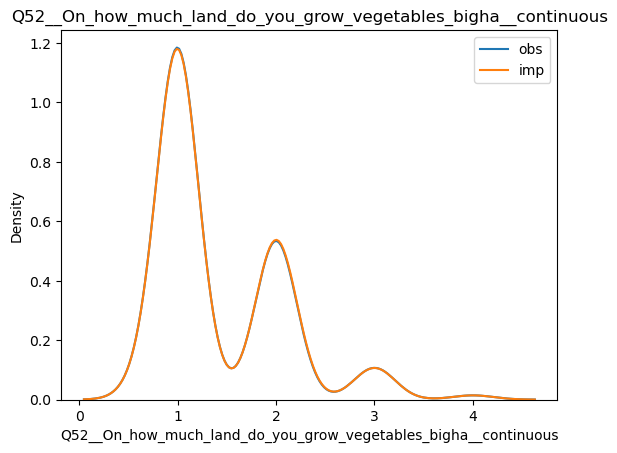

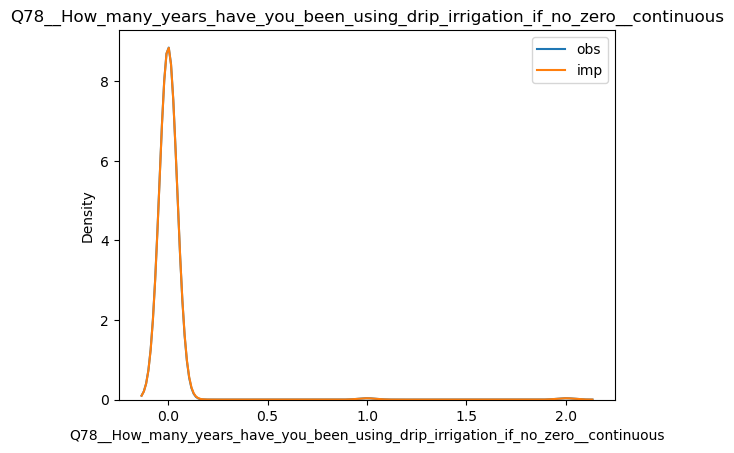

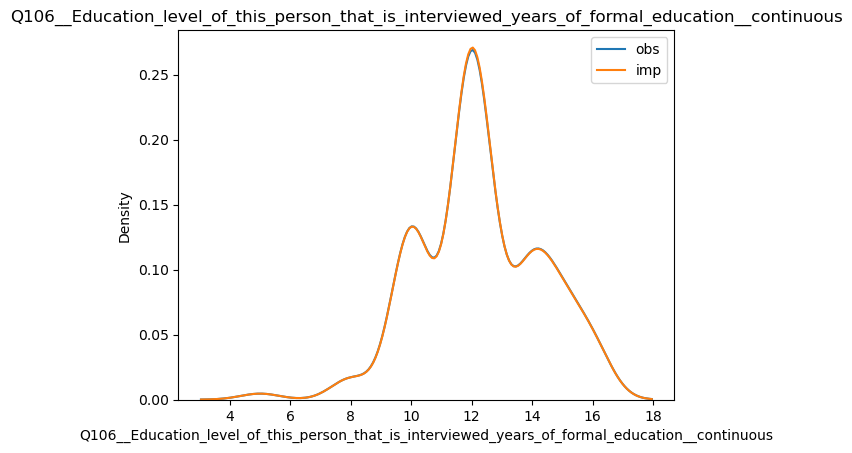

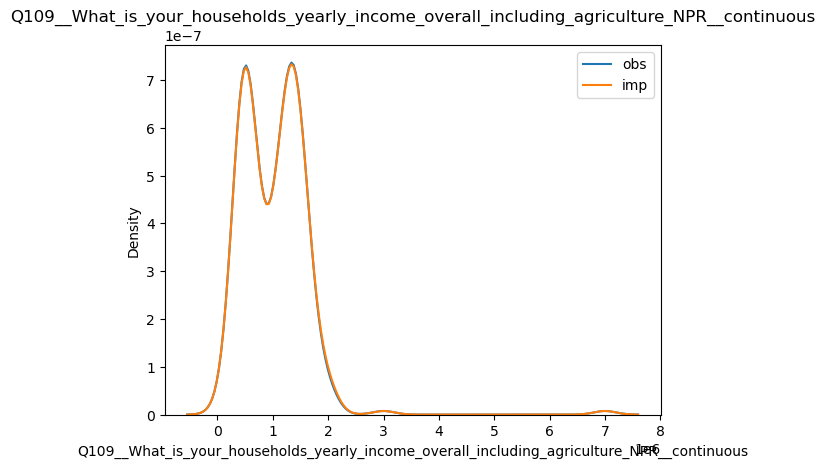

In [2433]:
for col in nepal_num_missing_cols:
    sns.kdeplot(nepal_df[col].dropna(), label="obs")
    sns.kdeplot(imp_n_df[col], label="imp")
    plt.legend(); plt.title(col); plt.show()


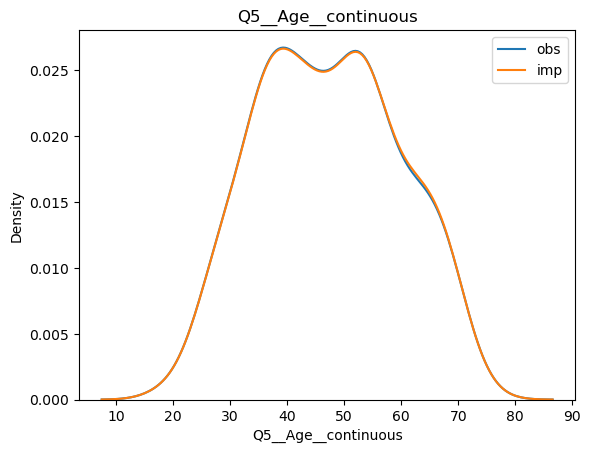

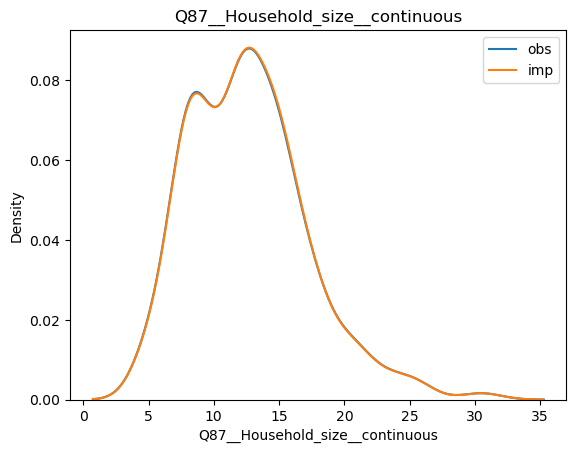

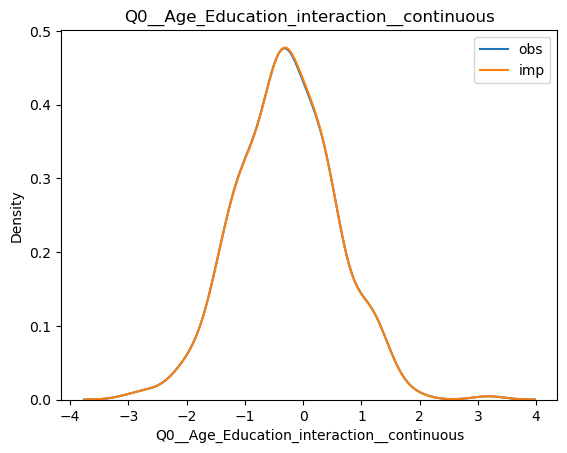

In [2434]:
for col in senegal_num_missing_cols:
    sns.kdeplot(senegal_df[col].dropna(), label="obs")
    sns.kdeplot(imp_s_df[col], label="imp")
    plt.legend(); plt.title(col); plt.show()

Apply to original datasets

In [2435]:
nepal_df = imp_n_df
senegal_df = imp_s_df

Recheck missing values in both datasets

In [2436]:
missing_counts_nepal = nepal_df.isnull().sum()
print("Missing values per column in nepal:")
print(missing_counts_nepal[missing_counts_nepal>0])

Missing values per column in nepal:
Series([], dtype: int64)


In [2437]:
missing_counts_senegal = senegal_df.isnull().sum()
print("Missing values per column in senegal:")
print(missing_counts_senegal[missing_counts_senegal>0])

Missing values per column in senegal:
Series([], dtype: int64)


In [2438]:
nom_vars = [c for c in senegal_df.columns if c.endswith("__nominal")]
nom_vars

['Q4__Phone_Number__nominal',
 'Q6__Arrondissement__nominal',
 'Q7__name_of_village__nominal',
 'Q78__Names_of_organizations__nominal',
 'Q85__Group__nominal',
 'Q63__CROP__nominal',
 'Q64__Seed_source__nominal',
 'Q65__Variety__nominal',
 'Q66__Seedlings__nominal',
 'Q67__Fertilizer__nominal',
 'Q72__Sold_VEG__nominal',
 'Q73__Machinery__nominal',
 'Q74__Practice__nominal',
 'Q77__Info_source__nominal',
 'Q79__Did_you_receive_anything_from_the_specified_organizations__nominal',
 'Q80__Plow_weather__nominal',
 'Q81__Sow__nominal',
 'Q82__Irrigation__nominal',
 'Q88__family_main_sources_income__nominal']

# Convert Nominals to Numeric

In [2439]:
# ── imports ───────────────────────────────────────────────────────────────────
import numpy as np
import pandas as pd
import warnings
import prince

# ── binary + fallback encoders ────────────────────────────────────────────────
def _encode_binary(s: pd.Series) -> pd.Series:
    """Map a ≤2-level nominal to 0/1 (nullable Int64); NaNs preserved."""
    cats = pd.Categorical(s)
    codes = pd.Series(cats.codes, index=s.index)
    return codes.replace(-1, np.nan).astype("Int64")  # -1 marks NaN in pandas codes

def _encode_multilevel_as_codes(s: pd.Series) -> pd.Series:
    """Ordinal-style integer codes for a >2-level nominal when MCA is not run."""
    cats = pd.Categorical(s)
    codes = pd.Series(cats.codes, index=s.index)
    return codes.replace(-1, np.nan).astype("Int64")

# ── version-robust inertia extractor ─────────────────────────────────────────
def _mca_inertia(mca) -> np.ndarray:
    """
    Return per-component proportion of inertia (variance) for a fitted prince.MCA.
    Works across prince API changes.
    """
    # Old API
    if hasattr(mca, "explained_inertia_"):
        return np.asarray(getattr(mca, "explained_inertia_"), dtype=float)

    # Newer API (mirrors PCA page: percentage_of_variance_)
    if hasattr(mca, "percentage_of_variance_"):
        perc = np.asarray(getattr(mca, "percentage_of_variance_"), dtype=float)
        if perc.max() > 1:  # expressed as %
            perc = perc / 100.0
        return perc

    # Fallback: compute from eigenvalues / total inertia
    eig = np.asarray(getattr(mca, "eigenvalues_", []), dtype=float)
    if eig.size == 0:
        return np.array([])
    total = getattr(mca, "total_inertia_", None)
    if total is None or float(total) == 0.0:
        total = eig.sum()
    else:
        total = float(total)
    return eig / total

# ── print helper ──────────────────────────────────────────────────────────────
def _print_mca_category_table(name, mca, block, k):
    """
    Print category coordinates for the first k dimensions and list top contributors
    (by absolute coordinate) to aid interpretation.
    """
    col_coords = mca.column_coordinates(block).iloc[:, :k]
    with pd.option_context("display.max_rows", None, "display.max_columns", None):
        print(f"\n{name} – category coordinates (first {k} dim(s))")
        print(col_coords)
        for i in range(k):
            ordered = col_coords.iloc[:, i].abs().sort_values(ascending=False)
            top = ordered.head(10).index.tolist()
            print(f"  Dim{i+1} | top |{top}")

# ── main thematic MCA driver ──────────────────────────────────────────────────
def thematic_mca(df: pd.DataFrame,
                 groups: dict,
                 prefix: str,
                 inertia_threshold: float = 0.60,
                 correction="benzecri",
                 max_dims: int = 20,
                 na_token: str = "__NA__") -> pd.DataFrame:
    """
    Add MCA dimensions (per thematic group) + binary encodings to df.

    Parameters
    ----------
    df : DataFrame
        Source data (will be copied; original left untouched).
    groups : dict[str, list[str]]
        Mapping group_name -> list of column names in df.
    prefix : str
        Prefix for new columns (e.g., 'NP' or 'SN').
    inertia_threshold : float
        Minimum cumulative inertia required; keep the smallest k meeting/exceeding it.
    max_dims : int
        Upper bound on components requested from prince (safety).
    na_token : str
        Temporary string used to mark missing categories before MCA.

    Returns
    -------
    DataFrame with new numeric columns appended.
    """
    df = df.copy()

    for grp_name, cols in groups.items():
        cols = [c for c in cols if c in df.columns]
        if not cols:
            continue

        # Encode any binary nominals immediately
        for c in cols:
            if df[c].nunique(dropna=True) <= 2:
                df[f"Q0__BIN_NOM_{grp_name}_{c}__binary_1"] = _encode_binary(df[c])

        # Identify multi-category columns (>2 levels)
        multi_cols = [c for c in cols if df[c].nunique(dropna=True) > 2]
        if len(multi_cols) == 0:
            continue

        # Degenerate case: only one multi-category variable -> just codes
        if len(multi_cols) == 1:
            c = multi_cols[0]
            df[f"Q0_{grp_name}_{c}_code__ordinal"] = _encode_multilevel_as_codes(df[c])
            warnings.warn(
                f"{prefix}:{grp_name} has only one multi-category variable; MCA skipped."
            )
            continue

        # Build block & fit MCA
        block = df[multi_cols].astype(str).fillna(na_token)

        # The theoretical rank of MCA on K variables is (#levels_total - K);
        # request a reasonable upper bound.
        n_comp = max(2, min(max_dims, block.shape[1] - 1))
        mca = prince.MCA(n_components=n_comp, random_state=42, correction=correction).fit(block)

        # Decide how many dims to keep
        inertia = _mca_inertia(mca)
        if inertia.size == 0:
            warnings.warn(f"{prefix}:{grp_name} inertia unavailable; keeping first dim.")
            k = 1
            cum = np.array([np.nan])
        else:
            cum = np.cumsum(inertia)
            k = np.searchsorted(cum, inertia_threshold) + 1
            k = min(k, len(inertia))

        # Append MCA scores
        scores = mca.transform(block).iloc[:, :k]
        scores.columns = [f"Q0__MCA_{grp_name}_dim{i+1}__continuous" for i in range(k)]
        df = pd.concat([df, scores], axis=1)

        pct = cum[k-1] if np.isfinite(cum[k-1]) else float("nan")
        print(f"[{prefix}:{grp_name}] retained {k} dim(s) explaining {pct:.1%} of group inertia.")
        _print_mca_category_table(f"{prefix}:{grp_name}", mca, block, k)

    return df


# ── thematic groupings per country (tweak as needed) ────────────────────────
# ── Nepal thematic groups ─────────────────────────────────────────────────────
nepal_groups = {
    "global": ['Q7__District__nominal',
 'Q8__WardNumber__nominal',
 'Q9__NameOfVillage__nominal',
 'Q11__Marital_Status__nominal',
 'Q53__What_type_of_crop_is_grown_on_this_plot__nominal',
 'Q54__For_vegetables_what_is_your_source_of_seeds__nominal',
 'Q56__For_vegetables_do_you_use_seedlings__nominal',
 'Q58__fertilizer_on_this_plot__nominal',
 'Q63__What_is_the_main_use_of_produce_from_holding__nominal',
 'Q64__Do_you_use_machinery_or_and_equipment_on_the_plot__nominal',
 'Q65__Do_you_do_any_of_the_following__nominal',
 'Q74__How_do_you_decide_to_plow__nominal',
 'Q75__How_do_you_decide_to_begin_sowing__nominal',
 'Q76__What_type_of_irrigation_do_you_use__nominal',
 'Q100__Caste__nominal',
 'Q105__main_sources_of_income__nominal']
}

senegal_groups = {
    "global": ['Q6__Arrondissement__nominal',
 'Q7__name_of_village__nominal',
 'Q78__Names_of_organizations__nominal',
 'Q85__Group__nominal',
 'Q63__CROP__nominal',
 'Q64__Seed_source__nominal',
 'Q65__Variety__nominal',
 'Q66__Seedlings__nominal',
 'Q67__Fertilizer__nominal',
 'Q72__Sold_VEG__nominal',
 'Q73__Machinery__nominal',
 'Q74__Practice__nominal',
 'Q77__Info_source__nominal',
 'Q79__Did_you_receive_anything_from_the_specified_organizations__nominal',
 'Q80__Plow_weather__nominal',
 'Q81__Sow__nominal',
 'Q82__Irrigation__nominal',
 'Q88__family_main_sources_income__nominal']
}
# nepal_groups = {
#     "geo": [
#         "Q7__District__nominal", "Q8__WardNumber__nominal",
#         "Q9__NameOfVillage__nominal"
#     ],
#     "demography": [
#         "Q11__Marital_Status__nominal", "Q100__Caste__nominal",
#         "Q105__main_sources_of_income__nominal"
#     ],
#     "farming": [
#         "Q53__What_type_of_crop_is_grown_on_this_plot__nominal",
#         "Q54__For_vegetables_what_is_your_source_of_seeds__nominal",
#         "Q56__For_vegetables_do_you_use_seedlings__nominal",
#         "Q58__fertilizer_on_this_plot__nominal",
#         "Q63__What_is_the_main_use_of_produce_from_holding__nominal",
#         "Q64__Do_you_use_machinery_or_and_equipment_on_the_plot__nominal",
#         "Q65__Do_you_do_any_of_the_following__nominal",
#         "Q74__How_do_you_decide_to_plow__nominal",
#         "Q75__How_do_you_decide_to_begin_sowing__nominal",
#         "Q76__What_type_of_irrigation_do_you_use__nominal",
#     ],
# }

# senegal_groups = {
#     "geo-econom-social": [
#         "Q6__Arrondissement__nominal", "Q7__name_of_village__nominal",
#         "Q88__family_main_sources_income__nominal", "Q85__Group__nominal"
#     ],
#     "orgs": [
#         "Q78__Names_of_organizations__nominal",
#         "Q79__Did_you_receive_anything_from_the_specified_organizations__nominal",
#     ],
#     "farming": [
#         "Q63__CROP__nominal", "Q64__Seed_source__nominal",
#         "Q65__Variety__nominal", "Q66__Seedlings__nominal",
#         "Q67__Fertilizer__nominal", "Q72__Sold_VEG__nominal",
#         "Q73__Machinery__nominal", "Q74__Practice__nominal",
#         "Q77__Info_source__nominal", "Q80__Plow_weather__nominal",
#         "Q81__Sow__nominal", "Q82__Irrigation__nominal",
#     ]
# }

# ── run thematic MCA ──────────────────────────────────────────────────────────
nepal_df   = thematic_mca(nepal_df,   nepal_groups,   prefix="NP", inertia_threshold=0.95)
senegal_df = thematic_mca(senegal_df, senegal_groups, prefix="SN", inertia_threshold=0.95)



[NP:global] retained 12 dim(s) explaining 95.1% of group inertia.

NP:global – category coordinates (first 12 dim(s))
                                                          0         1   \
Q7__District__nominal__6                           -0.857736 -0.082136   
Q7__District__nominal__illam                        0.495390 -0.085674   
Q7__District__nominal__jhapa                       -0.000502  0.000957   
Q8__WardNumber__nominal__1                         -1.249548 -0.438132   
Q8__WardNumber__nominal__10                         0.718495 -0.306840   
Q8__WardNumber__nominal__2                         -0.967706 -0.316576   
Q8__WardNumber__nominal__3                         -0.646890  0.087128   
Q8__WardNumber__nominal__4                          0.333598 -0.244240   
Q8__WardNumber__nominal__5                          0.508993  0.481215   
Q8__WardNumber__nominal__6                          0.770768 -0.059283   
Q8__WardNumber__nominal__7                          0.363034  0.5763

In [2440]:
nepal_df = drop_non_relevant_columns(nepal_df)
senegal_df = drop_non_relevant_columns(senegal_df)

In [2441]:
nepal_num_cols = [c for c in nepal_df.columns if parse_feature_metadata(c)["type"] == "continuous"]
senegal_num_cols = [c for c in senegal_df.columns if parse_feature_metadata(c)["type"] == "continuous"]

# Outliers

In [2442]:
import pandas as pd
from helpers import parse_feature_metadata


def treat_global_outliers(
    df: pd.DataFrame,
    lower_q: float = 0.005,
    upper_q: float = 0.95,
    method: str = "clip",
    *,
    inplace: bool = False,
) -> pd.DataFrame:
    """
    Winsorize, mask, or remove extreme values in continuous features,
    using *global* quantile cut-offs.

    Parameters
    ----------
    df : pandas.DataFrame
        Input data frame containing survey features.
    lower_q, upper_q : float
        Quantiles that define the lower / upper bounds (defaults: 0.5 %,
        95 %).  Use more extreme cut-offs (e.g. 0.001 / 0.999) if you want
        to drop only the most egregious values.
    method : {'clip', 'mask', 'drop'}
        'clip' – winsorise values to the bounds (traditional behaviour).  
        'drop' – discard any row that contains an outlier in a continuous
                 column.
    inplace : bool, default False
        Operate on *df* itself if True; otherwise work on a copy.

    Returns
    -------
    pandas.DataFrame
        Data frame with outliers treated according to *method*.
    """
    if method not in {"clip", "mask", "drop"}:
        raise ValueError("method must be 'clip', 'mask', or 'drop'")

    out = df if inplace else df.copy()

    # --- identify continuous columns ----------------------------------------
    cont_cols = [
        col
        for col in out.columns
        if (meta := parse_feature_metadata(col)) and meta["type"] == "continuous"
    ]
    if not cont_cols:
        return out  # nothing to do

    # --- global boundaries ---------------------------------------------------
    s = out[cont_cols].stack()
    low, high = s.quantile(lower_q), s.quantile(upper_q)

    # --- apply chosen treatment ---------------------------------------------
    if method == "clip":
        out[cont_cols] = out[cont_cols].clip(lower=low, upper=high)

    elif method == "drop":  # method == "drop"
        mask = out[cont_cols].apply(lambda col: col.between(low, high))
        out = out[mask.all(axis=1)].copy()

    return out



In [2443]:
nepal_df = treat_global_outliers(nepal_df, 0.001, 0.999, method="drop")
senegal_df = treat_global_outliers(senegal_df, 0.001, 0.999, method="drop")


# Create Productivity Metric Columns (Targets)

In [2444]:
def standardize(x):
    return (x - x.mean()) / x.std()

In [2445]:

NPL_YEARLY_AGR_INCOME_COL = "Q108__What_is_your_households_yearly_income_from_agriculture_NPR__continuous"
SNGL_YEARLY_AGR_INCOME_COL = 'Q90__Yearly_income_agriculture_XOF__continuous'
NPL_OWND_CULTVTD_LAND_COL = "Q50__How_much_land_that_is_yours_do_you_cultivate_bigha__continuous"
SNGL_OWND_CULTVTD_LAND_COL = "Q60__Land_owned_cultivated_ha__continuous"
NPL_LEAS_CULTVTD_LAND_COL = "Q51__How_much_land_that_is_rented_or_leased_do_you_cultivate_bigha__continuous"
SNGL_LEAS_CULTVTD_LAND_COL = "Q61__Land_rented_cultivated_ha__continuous"
NPL_VEG_HARVEST_PER_YEAR_COL = "Q62__How_much_VEGETABLES_do_you_harvest_per_year_from_this_plot_kilograms__continuous"
SNGL_VEG_HARVEST_PER_YEAR_COL = "Q71__VEG_harvest_per_year_kg__continuous"
NPL_SELF_REPORTED_FARM_LEVEL_COL = "Q112__Generally_speaking_how_would_you_define_your_farming__ordinal"
SNGL_SELF_REPORTED_FARM_LEVEL_COL = "Q94__Farming_level_relative__ordinal"
NPL_VEG_LAND = "Q52__On_how_much_land_do_you_grow_vegetables_bigha__continuous"
SNGL_VEG_LAND = "Q62__Land_grow_vegetables_ha__continuous"

nepal_df['yearly_income_from_agr_per_land_Z'] = ((nepal_df[NPL_YEARLY_AGR_INCOME_COL].transform(standardize)) / (nepal_df[NPL_OWND_CULTVTD_LAND_COL].transform(standardize) + nepal_df[NPL_LEAS_CULTVTD_LAND_COL].transform(standardize))).transform(standardize)
senegal_df['yearly_income_from_agr_per_land_Z'] = ((senegal_df[SNGL_YEARLY_AGR_INCOME_COL].transform(standardize)) / (senegal_df[SNGL_OWND_CULTVTD_LAND_COL].transform(standardize) + senegal_df[SNGL_LEAS_CULTVTD_LAND_COL].transform(standardize))).transform(standardize)

nepal_df['yearly_income_from_agr_Z'] = nepal_df[NPL_YEARLY_AGR_INCOME_COL].transform(standardize)
senegal_df['yearly_income_from_agr_Z'] = senegal_df[SNGL_YEARLY_AGR_INCOME_COL].transform(standardize)

nepal_df['veg_per_area_Z'] = (nepal_df[NPL_VEG_HARVEST_PER_YEAR_COL].transform(standardize) / nepal_df[NPL_VEG_LAND].transform(standardize)).transform(standardize)
senegal_df['veg_per_area_Z'] = (senegal_df[SNGL_VEG_HARVEST_PER_YEAR_COL].transform(standardize) / senegal_df[SNGL_VEG_LAND].transform(standardize)).transform(standardize)

nepal_df['self_farming_perception_Z'] = nepal_df[NPL_SELF_REPORTED_FARM_LEVEL_COL].transform(standardize)
senegal_df['self_farming_perception_Z'] = senegal_df[SNGL_SELF_REPORTED_FARM_LEVEL_COL].transform(standardize)

# defragment
nepal_df = nepal_df.copy()
senegal_df = senegal_df.copy()

target_cols = ['yearly_income_from_agr_per_land_Z',
               'yearly_income_from_agr_Z',
               'veg_per_area_Z',
               'self_farming_perception_Z']




In [2446]:
from sklearn.decomposition import PCA
from typing import Literal

def reduce_to_index(
        df: pd.DataFrame,
        cols: list[str],
        index_name: str,
        n_components: int = 1,
        collapse_method: Literal["keep", "weighted-avg"] = "keep"
    ) -> tuple[pd.DataFrame, pd.DataFrame, np.ndarray, np.ndarray]:
    """
    Runs PCA on `cols`, retains the first `n_components`, and either
    keeps them as separate columns or collapses them into one index.

    Parameters
    ----------
    df : original DataFrame (unchanged)
    cols : list of column names to run PCA on
    index_name : base name for new column(s)
    n_components : how many PCs to keep (1 or 2 for your case)
    collapse_method :
        "keep"         -> add PC1, PC2, ... separately
        "weighted-avg" -> single index = Σ w_i * PC_i, w_i = var-ratio_i

    Returns
    -------
    df_out : DataFrame with original cols dropped & new columns added
    loadings_df : each variable’s loading on the retained PCs
    eigenvals : eigenvalues of retained PCs
    var_ratios : proportion of variance explained by each retained PC
    """
    if n_components < 1:
        raise ValueError("n_components must be >= 1")

    # 1. Fit PCA
    pca = PCA(n_components=n_components).fit(df[cols])
    scores      = pca.transform(df[cols])            # shape (n_samples, n_components)
    eigenvals   = pca.explained_variance_            # length = n_components
    var_ratios  = pca.explained_variance_ratio_
    comps       = pca.components_                    # shape (n_components, n_features)

    # 2. Compute loadings for retained PCs
    #    loading_ij = component_ij * sqrt(eigenval_i)
    loadings = comps * np.sqrt(eigenvals[:, None])   # broadcasting
    loadings_df = pd.DataFrame(
        loadings.round(4).T,
        index=cols,
        columns=[f"{index_name}_PC{i+1}" for i in range(n_components)]
    )

    # 3. Build output DataFrame
    df_out = df.drop(columns=cols).copy()
    weights = var_ratios / var_ratios.sum()          # normalise if <1
    composite = (scores * weights).sum(axis=1)
    df_out[index_name] = composite

    return df_out, loadings_df, var_ratios


In [2447]:
corr = nepal_df[target_cols].corr(method="pearson")   # default is Pearson
corr.style.background_gradient(vmin=-1, vmax=1, cmap="coolwarm")  # red-blue scale

,yearly_income_from_agr_per_land_Z,yearly_income_from_agr_Z,veg_per_area_Z,self_farming_perception_Z
yearly_income_from_agr_per_land_Z,1.000000,-0.026213,0.158141,-0.001212
yearly_income_from_agr_Z,-0.026213,1.000000,-0.093709,0.658135
veg_per_area_Z,0.158141,-0.093709,1.000000,-0.251797
self_farming_perception_Z,-0.001212,0.658135,-0.251797,1.000000


In [2448]:
nepal_df, loadings, var = reduce_to_index(nepal_df, target_cols, index_name='Q0__AGR_PROD__continuous', n_components=2)
print(loadings)
print(var)

                                   Q0__AGR_PROD__continuous_PC1  \
yearly_income_from_agr_per_land_Z                       -0.1241   
yearly_income_from_agr_Z                                 0.8535   
veg_per_area_Z                                          -0.4374   
self_farming_perception_Z                                0.9006   

                                   Q0__AGR_PROD__continuous_PC2  
yearly_income_from_agr_per_land_Z                        0.8124  
yearly_income_from_agr_Z                                 0.2561  
veg_per_area_Z                                           0.5973  
self_farming_perception_Z                                0.1593  
[0.43655589 0.27693966]


In [2449]:
corr = senegal_df[target_cols].corr(method="pearson")   # default is Pearson
corr.style.background_gradient(vmin=-1, vmax=1, cmap="coolwarm")  # red-blue scale

,yearly_income_from_agr_per_land_Z,yearly_income_from_agr_Z,veg_per_area_Z,self_farming_perception_Z
yearly_income_from_agr_per_land_Z,1.000000,0.454821,0.617843,0.159806
yearly_income_from_agr_Z,0.454821,1.000000,0.241735,0.375051
veg_per_area_Z,0.617843,0.241735,1.000000,0.053391
self_farming_perception_Z,0.159806,0.375051,0.053391,1.000000


In [2450]:
senegal_df, loadings, var = reduce_to_index(senegal_df, target_cols, index_name='Q0__AGR_PROD__continuous', n_components=2)
print(loadings)
print(var)

                                   Q0__AGR_PROD__continuous_PC1  \
yearly_income_from_agr_per_land_Z                        0.8546   
yearly_income_from_agr_Z                                 0.7329   
veg_per_area_Z                                           0.7286   
self_farming_perception_Z                                0.4500   

                                   Q0__AGR_PROD__continuous_PC2  
yearly_income_from_agr_per_land_Z                       -0.2878  
yearly_income_from_agr_Z                                 0.3770  
veg_per_area_Z                                          -0.5179  
self_farming_perception_Z                                0.7711  
[0.50022434 0.27196522]


# Create Resilience Index

Get access to basic services features for each country

In [2451]:
def add_abs_features(
    df: pd.DataFrame,
    lat_col: str = "lat",
    lon_col: str = "lon",
    water_thresh: float = 100,   # meters
    toilet_thresh: float = 50,    # meters
    elec_thresh: float = 100      # meters
) -> pd.DataFrame:
    """
    Enrich any DataFrame with (lat,lon) cols by adding:
      • abs_water_access  (0/1)
      • abs_toilet        (0/1)
      • abs_electricity   (0/1)
    plus these distance columns (in meters):
      dist_water_source, dist_toilet, dist_power_line,
      dist_primary_school, dist_health_facility,
      dist_livestock_market, dist_agri_market,
      dist_public_transport
    """
    # 1. Rename & build GeoDataFrame in EPSG:4326 → project to EPSG:3857 for meters
    df2 = df.rename(columns={lat_col: "lat", lon_col: "lon"}).copy()
    gdf = gpd.GeoDataFrame(
        df2,
        geometry=gpd.points_from_xy(df2.lon, df2.lat),
        crs="EPSG:4326"
    ).to_crs(epsg=3857)

    def add_osm_distance(gdf, tags: dict, col: str):
        # compute lat/lon bbox from projected gdf
        north, south, east, west = gdf.to_crs(epsg=4326).total_bounds[[3,1,2,0]]
        pad = 0.02  # degrees
        north += pad; south -= pad; east += pad; west -= pad
        bbox = (west, south, east, north)  # (left, bottom, right, top)

        # fetch POIs within bbox; signature is features_from_bbox(bbox, tags) :contentReference[oaicite:1]{index=1}
        pois = ox.features_from_bbox(bbox, tags)

        if pois.empty:
            gdf[col] = np.nan
        else:
            # merge all geometries to speed up distance queries
            geom_union = pois.to_crs(epsg=3857).geometry.unary_union
            gdf[col] = gdf.geometry.apply(lambda p: p.distance(geom_union))
        return gdf

    # 2. Compute each service distance
    gdf = add_osm_distance(gdf, {"amenity":"drinking_water"},     "dist_water_source")
    gdf = add_osm_distance(gdf, {"amenity":"toilets"},            "dist_toilet")
    gdf = add_osm_distance(gdf, {"power":"line"},                 "dist_power_line")
    gdf = add_osm_distance(gdf, {"amenity":"school"},             "dist_primary_school")
    gdf = add_osm_distance(gdf, {"amenity":["hospital","clinic"]},"dist_health_facility")
    gdf = add_osm_distance(gdf, {"amenity":"marketplace"},        "dist_livestock_market")
    gdf = add_osm_distance(gdf, {"shop":"greengrocer"},           "dist_agri_market")
    # public transport = nearest of bus_station or bus_stop
    gdf = add_osm_distance(gdf, {"amenity":"bus_station"},        "dist_bus_station")
    gdf = add_osm_distance(gdf, {"highway":"bus_stop"},           "dist_bus_stop")
    gdf["dist_public_transport"] = gdf[["dist_bus_station","dist_bus_stop"]].min(axis=1)

    # 4. Return original + ABS columns
    cols = [
      "dist_water_source","dist_toilet","dist_power_line",
      "dist_primary_school","dist_health_facility",
      "dist_livestock_market","dist_agri_market","dist_public_transport"
    ]
    df2 = df.rename(columns={"lat": lat_col, "lon": lon_col}).copy()
    return pd.concat([df2.reset_index(drop=True), gdf[cols].reset_index(drop=True)], axis=1)

In [2452]:
nepal_df_abs = add_abs_features(
    nepal_df.copy(),
    lat_col="Q1__Latitude__continuous",
    lon_col="Q1__Longitude__continuous"
)

senegal_df_abs = add_abs_features(
    senegal_df.copy(),
    lat_col="Q1__Latitude__continuous",
    lon_col="Q1__Longitude__continuous"
)

C:\Users\nadav\AppData\Local\Temp\ipykernel_39888\2725292146.py:42: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom_union = pois.to_crs(epsg=3857).geometry.unary_union
C:\Users\nadav\AppData\Local\Temp\ipykernel_39888\2725292146.py:42: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom_union = pois.to_crs(epsg=3857).geometry.unary_union
C:\Users\nadav\AppData\Local\Temp\ipykernel_39888\2725292146.py:42: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom_union = pois.to_crs(epsg=3857).geometry.unary_union
C:\Users\nadav\AppData\Local\Temp\ipykernel_39888\2725292146.py:42: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom_union = pois.to_crs(epsg=3857).geometry.unary_union
C:\Users\nadav\AppData\Local\Temp\ipykernel_39888\2725292146.py:42: DeprecationWarning: 

Using access to basic services features and other features create a composite sustainable livelihood score for farmers

In [2453]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


def _ordinal_to_numeric(frame: pd.DataFrame) -> pd.DataFrame:
    """
    Replace every *ordered* categorical column by its `.cat.codes`
    (-1 becomes NaN so it is picked up by the later fillna).
    """
    for col in frame.select_dtypes(include="category").columns:
        if not frame[col].cat.ordered:
            raise TypeError(
                f"Column {col} is categorical but not ordered; "
                "decide whether to one-hot encode, drop, or reorder it."
            )
        # codes: first category→0, second→1, …; missing→-1
        frame[col] = (
            frame[col]
            .cat.codes                     # integers, -1 for NaN
            .replace(-1, pd.NA)            # keep missing values explicit
            .astype("Float64")             # nullable float
        )
    return frame

def compute_sustainable_livelihood_score(
    df: pd.DataFrame,
    country: str
) -> pd.DataFrame:
    """
    Compute a 0–1 'sustainable_livelihood_score' as a formative composite
    across five livelihood domains, using PCA(1+2) per domain where needed.
    """
    df = df.copy()
    country = country.lower()
    
    # ── 1. Domain → feature lists ──────────────────────────────────────────
    if country == "nepal":
        domain_features = {
            "natural": [
                "Q50__How_much_land_that_is_yours_do_you_cultivate_bigha__continuous",
                "Q51__How_much_land_that_is_rented_or_leased_do_you_cultivate_bigha__continuous",
                "Q52__On_how_much_land_do_you_grow_vegetables_bigha__continuous",
                "Q62__How_much_VEGETABLES_do_you_harvest_per_year_from_this_plot_kilograms__continuous",
                "Q0__TOTAL_AREA__continuous"
            ],
            "physical": [
                "Q55__For_Vegetables_do_you_use_improved_and_or_variety_seeds_yes__binary__1",
                "Q57__If_you_self_prepare_seedlings_how_Nursery__binary__1",
                "Q60__do_you_use_pesticides_or_herbicides_on_this_plot_Yes__binary__1",
                "Q78__How_many_years_have_you_been_using_drip_irrigation_if_no_zero__continuous",
                "dist_water_source","dist_toilet","dist_power_line",
                "dist_primary_school","dist_health_facility",
                "dist_livestock_market","dist_agri_market","dist_public_transport"
            ],
            "financial": [
                "Q108__What_is_your_households_yearly_income_from_agriculture_NPR__continuous",
                "Q109__What_is_your_households_yearly_income_overall_including_agriculture_NPR__continuous",
                "Q110__Do_you_currently_have_a_loan_if_no_zero_if_yes_amount_of_money_loaned_NPR__continuous",
                "Q70__in_the_past_12_months_did_you_receive_any_info_from_anyone_on_agriculture__binary__1"
            ],
            "human": [
                "Q101__how_many_people_live_in_this_household__continuous",
                "Q5__AgeYears__continuous",
                "Q106__Education_level_of_this_person_that_is_interviewed_years_of_formal_education__continuous",
                "Q107__Education_level_of_your_wife_husband_How_many_years_of_formal_education__continuous"
            ],
            "social": [
                "Q0__hope_total__continuous",
                "Q0__self_control_score__continuous"
            ]
        }

    elif country == "senegal":
        domain_features = {
            "natural": [
                "Q60__Land_owned_cultivated_ha__continuous",
                "Q61__Land_rented_cultivated_ha__continuous",
                "Q62__Land_grow_vegetables_ha__continuous",
                "Q71__VEG_harvest_per_year_kg__continuous"
            ],
            "physical": [
                "Q69__Use_pesticide_or_herbicide__binary__1",
                "Q84__Years_using_drip_irrigation__continuous",
                "Q76__Received_agri_info_last_12m__binary__1",
                "dist_water_source","dist_toilet","dist_power_line",
                "dist_primary_school","dist_health_facility",
                "dist_livestock_market","dist_agri_market","dist_public_transport"
            ],
            "financial": [
                "Q90__Yearly_income_agriculture_XOF__continuous",
                "Q91__Yearly_income_overall_XOF__continuous",
                "Q92__Current_loan_amount_XOF__continuous"
            ],
            "human": [
                "Q87__Household_size__continuous",
                "Q5__Age__continuous",
                "Q0__Education_years__continuous"
            ],
            "social": [
                "Q0__Hope_total__continuous",
                "Q93__Trust_most_people__ordinal"
            ]
        }
    else:
        raise ValueError("country must be 'nepal' or 'senegal'")

    # ── 2. Summarise each domain with PCA(1) or (1+2) ──────────────────────
    domain_evr    = {}
    domain_scores = pd.DataFrame(index=df.index)

    for domain, feats in domain_features.items():
        # a) subset, convert ordinals to numeric, fill, standardise
        X  = _ordinal_to_numeric(df[feats].copy())
        X  = X.fillna(X.mean())                 # now safe: all columns numeric
        Xs = StandardScaler().fit_transform(X)

        # b) fit two PCs and keep 1 or 1+2 as before
        pca                 = PCA(n_components=2, random_state=0).fit(Xs)
        evr1, evr2          = pca.explained_variance_ratio_
        comp1, comp2        = pca.transform(Xs).T
        score               = (evr1 * comp1 + evr2 * comp2) / (evr1 + evr2) \
                              if evr1 < 0.50 else comp1
        domain_evr[domain]  = evr1 + evr2 if evr1 < 0.50 else evr1
        domain_scores[f"{domain}_score"] = score

    # ── 3. Composite: variance‐weighted sum of domain scores ───────────────
    total_evr = sum(domain_evr.values())
    weights   = {d: evr / total_evr for d, evr in domain_evr.items()}

    df["Q0__sustainable_livelihood_score__continuous"] = \
        sum(domain_scores[f"{d}_score"] * w for d, w in weights.items())

    return df["Q0__sustainable_livelihood_score__continuous"], weights


# ── Usage ───────────────────────────────────────────────────────────────
nepal_df["Q0__sustainable_livelihood_score__continuous"], nepal_weights   = compute_sustainable_livelihood_score(nepal_df_abs,   country="nepal")
senegal_df["Q0__sustainable_livelihood_score__continuous"], senegal_weights = compute_sustainable_livelihood_score(senegal_df_abs, country="senegal")

print(nepal_df[["Q0__sustainable_livelihood_score__continuous"]].head())
print(f"{nepal_weights}")
print(senegal_df[["Q0__sustainable_livelihood_score__continuous"]].head())
print(f"{senegal_weights}")


   Q0__sustainable_livelihood_score__continuous
0                                      0.703369
1                                      0.441284
2                                      1.005535
3                                      1.167943
4                                     -0.296764
{'natural': np.float64(0.1700401459268286), 'physical': np.float64(0.1693705273556386), 'financial': np.float64(0.22112894816230816), 'human': np.float64(0.2089412255610914), 'social': np.float64(0.23051915299413325)}
   Q0__sustainable_livelihood_score__continuous
0                                      0.551009
1                                      0.692463
2                                      0.026829
3                                      0.298246
5                                      2.505552
{'natural': np.float64(0.22228630730624394), 'physical': np.float64(0.17116036719047129), 'financial': np.float64(0.202139332734013), 'human': np.float64(0.2318624094030483), 'social': np.float64(0.17255158

In [2454]:
nepal_df = drop_non_relevant_columns(nepal_df)
senegal_df = drop_non_relevant_columns(senegal_df)

# Category Counts

Get all categorical and binary columns

In [2455]:
cat_cols_nepal = []
cat_cols_senegal = []
for col in nepal_df.columns:
    meta_type = parse_feature_metadata(col)['type']
    if meta_type not in ['continuous', 'discrete', 'time']:
        cat_cols_nepal.append(col)

for col in senegal_df.columns:
    meta_type = parse_feature_metadata(col)['type']
    if meta_type not in ['continuous', 'discrete', 'time']:
        cat_cols_senegal.append(col)

Check that none have an overly large amount of categories

In [2456]:
unique_counts = nepal_df[cat_cols_nepal].nunique()
# 3. see which columns are OK (≤20) or not (>20)
ok      = unique_counts[ unique_counts <= 20 ]
too_many = unique_counts[ unique_counts  > 20 ]

print("Columns with ≤20 categories:\n", ok.sort_values(ascending=False))
print("\nColumns with >20 categories:\n", too_many.sort_values(ascending=False))


Columns with ≤20 categories:
 Q105__main_sources_of_income__nominal                                                        19
Q53__What_type_of_crop_is_grown_on_this_plot__nominal                                        15
Q65__Do_you_do_any_of_the_following__nominal                                                 12
Q8__WardNumber__nominal                                                                      10
Q75__How_do_you_decide_to_begin_sowing__nominal                                               9
                                                                                             ..
Q55__For_Vegetables_do_you_use_improved_and_or_variety_seeds_yes__binary__1                   2
Q57__If_you_self_prepare_seedlings_how_Nursery__binary__1                                     2
Q70__in_the_past_12_months_did_you_receive_any_info_from_anyone_on_agriculture__binary__1     2
Q58__fertilizer_on_this_plot__nominal                                                         2
Q60__do_yo

In [2457]:
unique_counts = senegal_df[cat_cols_senegal].nunique()
# 3. see which columns are OK (≤20) or not (>20)
ok      = unique_counts[ unique_counts <= 20 ]
too_many = unique_counts[ unique_counts  > 20 ]

print("Columns with ≤20 categories:\n", ok.sort_values(ascending=False))
print("\nColumns with >20 categories:\n", too_many.sort_values(ascending=False))


Columns with ≤20 categories:
 Q7__name_of_village__nominal                                         18
Q14__Hope_4_There_are_lots_of_ways_around_any_problem__ordinal        9
Q12__Hope_2_I_energetically_pursue_my_goals__ordinal                  8
Q11__Hope_1_I_can_think_of_many_ways_to_get_out_of_a_jam__ordinal     8
Q15__Hope_5_I_am_easily_downed_in_an_argument__ordinal                8
                                                                     ..
Q81__Sow__nominal                                                     3
Q0__Has_Education_Yes_No__binary__1                                   2
Q86__Sex_male__binary__1                                              2
Q69__Use_pesticide_or_herbicide__binary__1                            2
Q76__Received_agri_info_last_12m__binary__1                           2
Length: 72, dtype: int64

Columns with >20 categories:
 Q4__Phone_Number__nominal    112
Q73__Machinery__nominal       33
dtype: int64


Only telephone, village and machinery columns have large amounts of categories which makes sense

# Constant Columns

We remove all remaining columns that have only a single value as this adds no new information

In [2458]:
nepal_df = nepal_df.loc[:, nepal_df.nunique(dropna=False) > 1]
senegal_df = senegal_df.loc[:, senegal_df.nunique(dropna=False) > 1]

# Second Clean

Change phone number column to just binary yes no if he has a phone number

In [2459]:

nepal_df['Q4__PhoneNumberAndIsZeroIfNone__nominal'] = (nepal_df['Q4__PhoneNumberAndIsZeroIfNone__nominal'] == 0).astype(int)
senegal_df['Q4__Phone_Number__nominal'] = (senegal_df['Q4__Phone_Number__nominal'] == 0).astype(int)

In [2460]:
nepal_df.rename(columns={'Q4__PhoneNumberAndIsZeroIfNone__nominal' : 'Q4__HasPhoneNumber__binary__1'}, inplace=True)
senegal_df.rename(columns={'Q4__Phone_Number__nominal' : 'Q4__HasPhoneNumber__binary__1'}, inplace=True)


Scale all numeric columns and one hot encode all categorical columns, and deal with missing values in categorical columns by adding a 'missing' category

In [2461]:
# from sklearn.preprocessing import StandardScaler
# import re

# def scale_numeric_columns(df, scale_ordinal=True):
#     df = df.copy()
#     # Get non-categorical numeric columns
#     cols_to_scale = [col for col in df.columns if parse_feature_metadata(col)["type"] in ['continuous', 'discrete', 'ordinal' if scale_ordinal else None]]

#     for col in cols_to_scale:
#         median = df[col].median()
#         # this returns a new Series (up-cast to float64) and assigns it back
#         df[col] = df[col].fillna(median)
    
#     scaler = StandardScaler()
#     df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

#     return df


# def one_hot_encode_columns(df):
#     df = df.copy()
#     cols_to_dummies = []
#     cols_to_dummies_prefixes = []
#     for col in df.columns:
#         meta = parse_feature_metadata(col)
#         if meta["type"] in ['ordinal', 'nominal']:
#             # add it to columns to one hot encode along with its question number
#             cols_to_dummies_prefixes.append(f"{meta['qid']}__{meta['name']}")
#             cols_to_dummies.append((col, meta["type"]))
    
#     col_names_to_dummies, _ = zip(*cols_to_dummies) 
#     col_names_to_dummies = list(col_names_to_dummies)
#     # applying prefix to dummies according to our feature name format
#     dummies = pd.get_dummies(df[col_names_to_dummies], prefix_sep='_', prefix=cols_to_dummies_prefixes, columns=col_names_to_dummies, dtype=int)
    
#     def reformat(col):
#         qid, name = col.split("__")
#         return f"{qid}__{re.sub(r'[^A-Za-z0-9_]', '', name)}"

#     dummies = dummies.rename(columns=reformat)

#     # applying postfix to dummies according to our feature name format
#     rename_map = {}
#     for orig, type in cols_to_dummies:
#         # find all dummy cols that start with "<orig's qid>-<orig's name>"
#         group = [c for c in dummies.columns if c.startswith(f"{parse_feature_metadata(orig)['qid']}__{parse_feature_metadata(orig)['name']}")]
#         # enumerate them 1,2,3…
#         for i, col_name in enumerate(group, start=1):
#             rename_map[col_name] = f"{col_name}__binary_{type}__{i}"
            
#     dummies = dummies.rename(columns=rename_map)
#     df_other = df.drop(columns=col_names_to_dummies)
#     final_df = pd.concat([df_other, dummies], axis=1)
    
#     return final_df

def get_nominals(df):
    cols = []
    for col in df.columns:
        if parse_feature_metadata(col)['type'] == 'nominal':
            cols.append(col)
    return cols

def convert_ordinal_to_numeric(df):
    for col in df.columns:
        if parse_feature_metadata(col)['type'] == 'ordinal' and df[col].map(type).unique()[0] == str:
            if df[col].str.match(r'.*\d$').all():
                df[col] = df[col].apply(lambda x: int(x[-1]))
            elif df[col].cat.ordered:
                df[col] = df[col].cat.codes



Supervisor asked us to not use specific psychological indicators in our final method

In [2462]:


NEPAL_HOPE_QUESTIONS_RANGE = list(range(17,29))
NEPAL_FEELINGS_QUESTIONS_RANGE = list(range(30, 50))
NEPAL_SELF_CONTROL_QUESTIONS_RANGE = list(range(80, 100))
NEPAL_PSYCH_QUESTION_RANGE = NEPAL_HOPE_QUESTIONS_RANGE \
                            + NEPAL_FEELINGS_QUESTIONS_RANGE \
                            + NEPAL_SELF_CONTROL_QUESTIONS_RANGE

SENEGAL_HOPE_QUESTIONS_RANGE = list(range(11,23))
SENEGAL_CHARACTER_STRENGTH_QUESTIONS_RANGE = list(range(24, 60))
SENEGAL_PSYCH_QUESTION_RANGE = SENEGAL_HOPE_QUESTIONS_RANGE \
                                + SENEGAL_CHARACTER_STRENGTH_QUESTIONS_RANGE
# Q51 NPL and Q61 SNG only used for prod/sust indices, converting to ordinal and dropping log transformed one since produces MAD zero when calculating bicor

NEPAL_ADDITIONAL = ["Q0__positive_total__continuous", "Q0__negative_total__continuous", "Q1__Latitude__continuous", "Q1__Longitude__continuous", "Q1__Accuracy__continuous",
                    "Q78__How_many_years_have_you_been_using_drip_irrigation_if_no_zero__binary__1",
                    "Q51__How_much_land_that_is_rented_or_leased_do_you_cultivate_bigha__continuous"]
SENEGAL_ADDITIONAL = ["Q61__Land_rented_cultivated_ha__continuous"]
# NEPAL_ADDITIONAL = ["Q1__Latitude__continuous", "Q1__Longitude__continuous", "Q1__Accuracy__continuous", "Q50__How_much_land_that_is_yours_do_you_cultivate_bigha__continuous",
#                     "Q51__How_much_land_that_is_rented_or_leased_do_you_cultivate_bigha__continuous", "Q62__How_much_VEGETABLES_do_you_harvest_per_year_from_this_plot_kirams__continuous",
#                     "Q108__What_is_your_households_yearly_income_from_agriculture_NPR__continuous", "Q52__On_how_much_land_do_you_grow_vegetables_bigha__continuous",
#                     "Q0__positive_total__continuous", "Q0__negative_total__continuous"]
# SENEGAL_ADDITIONAL = ["Q1__Latitude__continuous", "Q1__Longitude__continuous", "Q1__Accuracy__continuous", "Q60__Land_owned_cultivated_ha__continuous", "Q61__Land_rented_cultivated_ha__continuous",
#                       "Q71__VEG_harvest_per_year_kg__continuous", "Q90__Yearly_income_agriculture_XOF__continuous", "Q69__Use_pesticide_or_herbicide__binary__1", "Q0__Distance_Thies_KM__continuous",
#                       "Q0__Distance_Dakar_KM__continuous", "Q62__Land_grow_vegetables_ha__continuous"]

def drop_ordinal_psych_columns(df, country):
    for col in df.columns:
        qid = int(parse_feature_metadata(col)["qid"].replace('Q', ''))
        if country == "NEPAL" and (qid in NEPAL_PSYCH_QUESTION_RANGE or col in NEPAL_ADDITIONAL):
            df.drop(col, axis=1, inplace=True)
        if country == "SENEGAL" and (qid in SENEGAL_PSYCH_QUESTION_RANGE or col in SENEGAL_ADDITIONAL):
            df.drop(col, axis=1, inplace=True)


In [2463]:
convert_ordinal_to_numeric(nepal_df)

drop_ordinal_psych_columns(nepal_df, "NEPAL")
nepal_df.to_excel("nepal_dataframe_FA.xlsx", index=False)

In [2464]:
convert_ordinal_to_numeric(senegal_df)

drop_ordinal_psych_columns(senegal_df, "SENEGAL")
senegal_df.to_excel("senegal_dataframe_FA.xlsx", index=False)
